<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/transfervgg16_small_2_85m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We continue our efforts to train a new smaller VGG model from the original VGG16 model. The number of parameters is 2.85M. The accuracy is about 0.924, and max accuracy is 0.941

# 1. Connecting to our Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/small/"

test  train  validation


#2. Prepare dataset

In [10]:
import keras
import os, shutil
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
import tensorflow.keras.backend as K
from keras.applications import VGG16

The directory where we will store our smaller dataset

In [11]:
base_dir = '/content/drive/My Drive/small'

 Directories for our smaller training and validation splits 

In [12]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Build the train imagedatagenerator

In [13]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

Note that the validation data should not be augmented!

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [16]:
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
         test_dir,
         target_size=(150, 150),
         batch_size=20,
         class_mode='binary')

Found 1000 images belonging to 2 classes.


# 3. Import VGG16 model

In [18]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

We lock all the layers of the convolutional part:

In [19]:
for layer in conv_model.layers:
    layer.trainable = False

Reduce the number of filters in the last CONV block.

In [48]:
#x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(conv_model.layers[6].output)
x=tf.keras.layers.MaxPooling2D(2)(conv_model.layers[8].output)
x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(x)
x=tf.keras.layers.MaxPooling2D(2)(x)
x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(x)
x=tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
# one dropout layer
x = keras.layers.Dropout(0.2)(x)
# one hidden layer
x = keras.layers.Dense(128, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

Now compile and train the model

In [50]:
full_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-4),  # retrain rate = 1e-4
              #optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])
			  
history = full_model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 220ms/step - loss: 1.2161 - acc: 0.7695 - val_loss: 0.6802 - val_acc: 0.6620
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.5565 - acc: 0.7425 - val_loss: 0.4037 - val_acc: 0.8320
Epoch 3/100
100/100 [==============================] - 21s 215ms/step - loss: 0.5203 - acc: 0.7640 - val_loss: 0.3347 - val_acc: 0.8610
Epoch 4/100
100/100 [==============================] - 21s 212ms/step - loss: 0.5077 - acc: 0.7735 - val_loss: 0.4750 - val_acc: 0.7810
Epoch 5/100
100/100 [==============================] - 21s 213ms/step - loss: 0.5038 - acc: 0.7660 - val_loss: 0.3169 - val_acc: 0.8680
Epoch 6/100
100/100 [==============================] - 22s 218ms/step - loss: 0.4584 - acc: 0.7905 - val_loss: 0.2881 - val_acc: 0.8710
Epoch 7/100
100/100 [==============================] - 21s 212ms/step - loss: 0.4552 - acc: 0.7995 - val_loss: 0.6963 - val_acc: 0.6830
Epoch 8/100
100/100 [===========================

In [51]:
full_model.save('cats_and_dogs_full_small-2.85m.h5')

In [52]:
from google.colab import files
files.download("cats_and_dogs_full_small-2.85m.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
print("Evaluate the full model on small test data")
results = full_model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate the full model on small test data
50/50 [==============================] - 4s 77ms/step - loss: 0.3414 - acc: 0.9240
test loss, test acc: [0.34140852093696594, 0.9240000247955322]


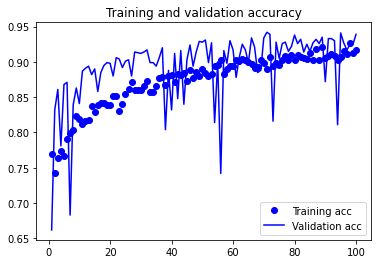

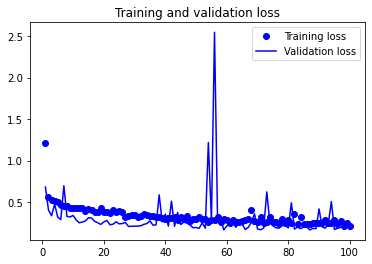

In [54]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()